# Analyze open data set of webstore Dream Market's "Cocaine" category

Determine what are the factors that influence price of cocaine, based on the dataset from  https://www.kaggle.com/everling/cocaine-listings
The dataset is approximately 1,400 cleaned and standardized product listings from Dream Market's "Cocaine" category. It was collected with web-scraping and text extraction techniques in July 2017.

As bonus questions, we can also:
- Compare Australian market with rest of the world 
- Determine if there is volume discount and how significant it is




# Table of contents
The main parts of this notebook are:
1. [Load data into DataFrames](#load)
1. [Check the data](#check)
1. [Data Analysis](#analysis)
    1. [Data visualisation to identity possible hypothesis](#raw_plots)   
    1. [Correlation matrix](#corr)
    1. [Data distribution](#distribution)
    1. [Summary and hypothesis](#hyp)
    
1. [Data Transformation and features engineering](#eng)
1. [Model and model evaluation](#model)
1. [Model Result](#model_result)
1. [Output Reports based on the model data](#summary)
    1. [Report 1 Gram of Q75 by Country of shipment](#rep_1)
    1. [Report 2 Cost per gram of Q90 by Grams Pack in Australia](#rep_2)
    1. [Report 3  Cost for 1 gram by Quality in AU](#rep_3)
    1. [Repot 4. Factor plot](#rep_4)
    
1. [Next steps](#next)


In [54]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, metrics


import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

<a name="load"></a>
## Upload Dreamworld Data set

In [55]:

#Read in data from source 
df_raw = pd.read_csv("dreamworld.csv")
print df_raw.head()


   Unnamed: 0                                      product_title  \
0          10              !!!!!INTRO OFFER!!!!! 1GR COCAINE 90%   
1          11              !!!!!INTRO OFFER!!!!! 2GR COCAINE 90%   
2          14  !!!INTRO!!! 0.5G COCAINE 89% - STRAIGHT FROM T...   
3          20  !1G! C O L O M B I A N C O C A I N E - 89% PURITY   
4          41      ** 1 Gram 87% Pure Uncut Colombian Cocaine **   

  ships_from_to  grams  quality  btc_price  cost_per_gram  cost_per_gram_pure  \
0    NL  â†’ EU    1.0     90.0    0.02577        0.02577            0.028633   
1    NL  â†’ EU    2.0     90.0    0.05150        0.02575            0.028611   
2    NL  â†’ EU    0.5     89.0    0.01649        0.03298            0.037056   
3    FR  â†’ EU    1.0     89.0    0.04120        0.04120            0.046292   
4    NL  â†’ WW    1.0     87.0    0.03400        0.03400            0.039080   

   Unnamed: 8  escrow      ...       ships_to_SE ships_from_SE ships_to_CO  \
0    0.028633       1     

<a name="check"></a>
### Check the data

In [56]:
#Data count check
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 65 columns):
Unnamed: 0                 1504 non-null int64
product_title              1504 non-null object
ships_from_to              1504 non-null object
grams                      1504 non-null float64
quality                    1504 non-null float64
btc_price                  1504 non-null float64
cost_per_gram              1504 non-null float64
cost_per_gram_pure         1504 non-null float64
Unnamed: 8                 1 non-null float64
escrow                     1504 non-null int64
product_link               1504 non-null object
vendor_link                1504 non-null object
vendor_name                1504 non-null object
successful_transactions    1504 non-null int64
rating                     1504 non-null float64
ships_from                 1504 non-null object
ships_to                   1504 non-null object
ships_to_US                1504 non-null bool
ships_from_US              150

*Result: There are 1504 rows with no NULL elements to be coniceder of. It seems the authtor has already done some initial cleaning work on the data set*

<a name="analysis"></a>
### Data analysis 



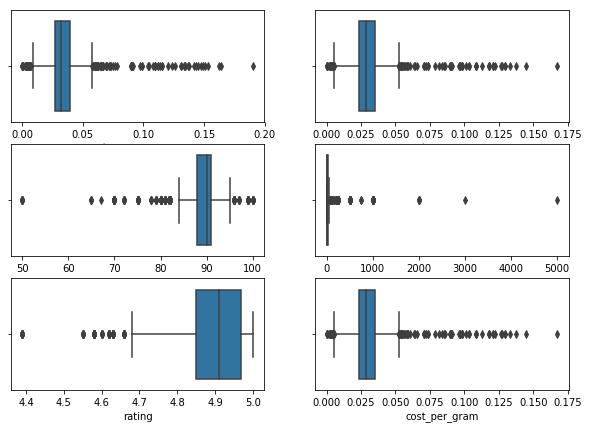

In [57]:
#lets identify the data distribution for predictors and output values

f, axes = plt.subplots(3, 2, figsize=(10, 7), sharex=False, sharey=False)

sns.boxplot(df_raw['cost_per_gram_pure'], ax=axes[0, 0])
sns.boxplot(df_raw['cost_per_gram'], ax=axes[0,1]) 
sns.boxplot(df_raw['quality'], ax=axes[1, 0])
sns.boxplot(df_raw['grams'], ax=axes[1,1]) 
sns.boxplot(df_raw['rating'], ax=axes[2,0]) 
sns.boxplot(df_raw['cost_per_gram'], ax=axes[2,1]) 

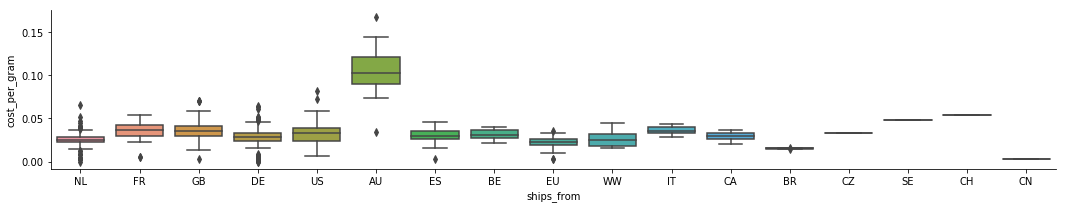

In [58]:
#visual on categorical variable ship from
sns.factorplot(
    x='ships_from',
    y='cost_per_gram',
    data=df_raw, 
    kind='box', 
    size = 3,
     aspect=5

)

*Result: The price is more or less the same across all countries except Australia, which has noticable difference in comarison to other countries. China has the least expecnsive, but it seems that number of offers is significantly lower*

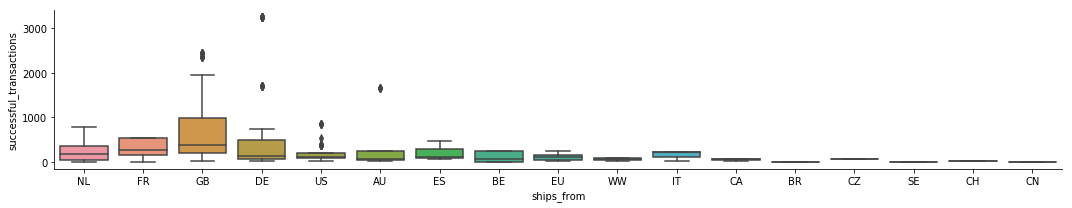

In [59]:
#visual on categorical variable ship from

sns.factorplot(
    x='ships_from',
    y='successful_transactions',
    data=df_raw, 
    kind='box', 
    size = 3,
     aspect=5

)

*Result: The highest number of transactions comes from GB. China has one of the lowest, Australia is also reprensented quite good on the market*

### Data visualisation to identity possible hypothesis
<a name="raw_plots"></a>

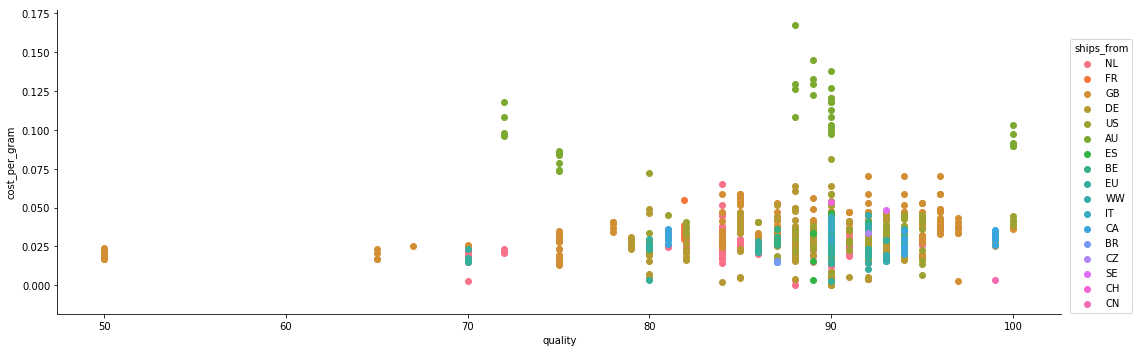

In [60]:
fg = sns.FacetGrid(df_raw[['quality', 'cost_per_gram', 'ships_from']], hue='ships_from',size=5, aspect=3)
fg.map(plt.scatter, 'quality', 'cost_per_gram').add_legend()

*result: surprisingly, quality has no significant impact on the price of the product* 

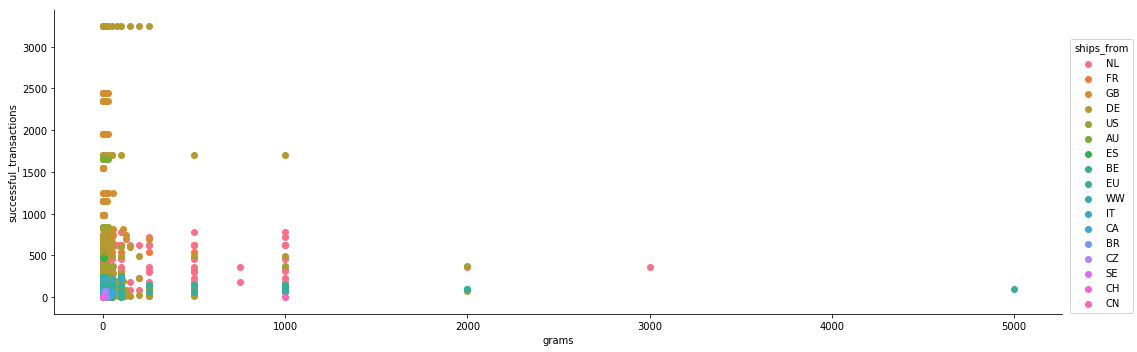

In [105]:
fg = sns.FacetGrid(df_raw[['grams', 'successful_transactions', 'ships_from']], hue='ships_from',size=5, aspect=3)
fg.map(plt.scatter, 'grams', 'successful_transactions', label="Grams per country").add_legend()

*result: there is a clear pattern, that the product is sold by packs aka conventional in community number of grams per transaction*

<a name="corr"></a>
### Correlation matrix

                       grams   quality  btc_price  cost_per_gram  \
grams               1.000000  0.030695   0.960451      -0.178628   
quality             0.030695  1.000000   0.027096       0.082540   
btc_price           0.960451  0.027096   1.000000      -0.171318   
cost_per_gram      -0.178628  0.082540  -0.171318       1.000000   
cost_per_gram_pure -0.178273 -0.064907  -0.170636       0.985784   
rating              0.009282 -0.055191   0.000539       0.121977   

                    cost_per_gram_pure    rating  
grams                        -0.178273  0.009282  
quality                      -0.064907 -0.055191  
btc_price                    -0.170636  0.000539  
cost_per_gram                 0.985784  0.121977  
cost_per_gram_pure            1.000000  0.126917  
rating                        0.126917  1.000000  


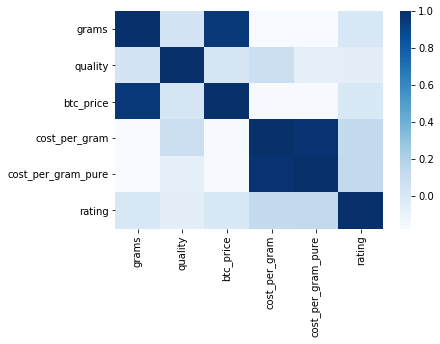

In [62]:
#check correlation
df_corr = df_raw[['grams', 'quality', 'btc_price', 'cost_per_gram', 'cost_per_gram_pure', 'rating']].corr()
print df_corr
sns.heatmap(df_corr, cmap="Blues")

*Correlation* between:
* cost per gram and cost per gram pure
* btc price and grams

what is interesting that no correlation between quality and cost per gram pure 

<a id="distribution"></a>

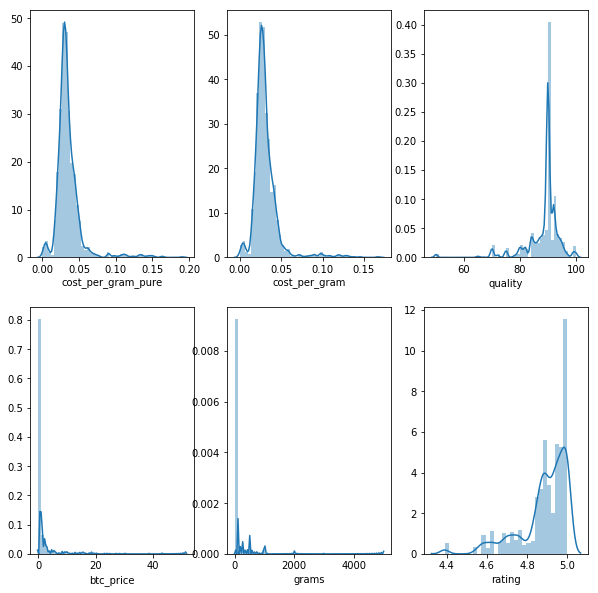

In [110]:
#Plot data distributions

# Set up the matplotlib figure
f, axes = plt.subplots(2, 3, figsize=(10, 10), sharex=False, sharey=False)

sns.distplot(df_raw['cost_per_gram_pure'], ax=axes[0, 0])
sns.distplot(df_raw['cost_per_gram'], ax=axes[0, 1])
sns.distplot(df_raw['quality'], ax=axes[0, 2])
sns.distplot(df_raw['btc_price'], ax=axes[1,0]) 
sns.distplot(df_raw['grams'], ax=axes[1,1]) 
sns.distplot(df_raw['rating'], ax=axes[1,2]) 



In [64]:
df_raw[['grams', 'quality', 'btc_price', 'cost_per_gram', 'cost_per_gram_pure', 'rating']].skew()  # Check skewness

grams                 10.125918
quality               -2.652266
btc_price              6.645111
cost_per_gram          3.383264
cost_per_gram_pure     3.540955
rating                -1.563335
dtype: float64

*Result: the data is quite skewed. will see how reasonable the model performs. We may need to do some extra work on it:*
* dropping some the first peak in *cost per gram*
* Check if we can drop some variable from the model


In [65]:
df_raw[['grams', 'quality', 'btc_price', 'cost_per_gram', 'cost_per_gram_pure', 'rating']].kurt()  # Check kurtosis

grams                 153.554542
quality                11.312141
btc_price              58.033234
cost_per_gram          17.302820
cost_per_gram_pure     18.453014
rating                  2.474713
dtype: float64

*Result: all results has a significant positive kurtosis. Some further actions may required* 

In [66]:
#pairplot is too busy with info, the correlation tble is ingo
#sns.pairplot(df_raw[['grams', 'quality', 'btc_price', 'cost_per_gram', 'cost_per_gram_pure', 'rating']])
#.apply(np.log)

<a name="hyp"></a>
### Results and hypotesis

Observations:
- Quality variable, despite on continues nature, has very strong patterns and has very limited options to select from. Due to the variable is not normal distributed I can assume that we can pack it into classes and analyse as categorical variable. For the sake of simplicity I use all of available quality options.
- Grams variable also has a very strong packing pattern. Most likely, use it as categorical variable will bring us better quality
- Quality has no correlation with other variables, even with Price
- Number of transactions in Europe is greater than in Australia, USA and significantly greater than in ASIA. My assumption is that the most trustful result should be about Europe. Reasonable assumptions may apply for other regions.

Hypothesis: 

The most influenced factors on cocaine price are the shipment location and transaction volume, based on the dataset of the dream market web shop.


<a id="eng"></a>
## Data Transformation and Feature engineering 

In [67]:
#Attemp to fix kurtosis and have better normal distribution by appling log function

df_raw['btc_price_log'] = df_raw['btc_price'].apply(np.log)


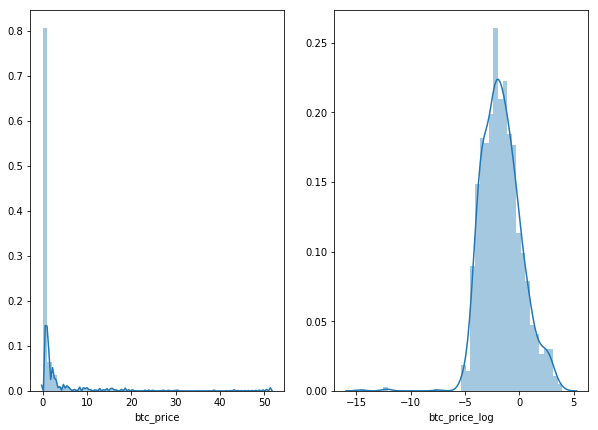

In [68]:
f, axes = plt.subplots(1, 2, figsize=(10, 7), sharex=False, sharey=False)

sns.distplot(df_raw['btc_price'], ax=axes[0])
sns.distplot(df_raw['btc_price_log'], ax=axes[1])

In [69]:
df_raw[['btc_price', 'btc_price_log']].kurt() # Check kurtosis

btc_price        58.033234
btc_price_log     2.900762
dtype: float64

*result: Log function improves kurtosis quite significanly. btc_price_log will be used as outcome variable *

### Add dummy Variables

In [70]:
print "grams  unique categories"
print df_raw['grams'].unique()

grams  unique categories
[  1.00000000e+00   2.00000000e+00   5.00000000e-01   1.00000000e+01
   3.00000000e+00   5.00000000e+00   1.40000000e+01   2.80000000e+01
   3.50000000e+00   7.00000000e+00   2.00000000e-01   1.00000000e+02
   5.00000000e+01   2.00000000e+01   2.50000000e-01   2.50000000e+01
   3.00000000e-01   3.50000000e-01   4.50000000e-01   4.00000000e-01
   4.00000000e+00   6.00000000e-01   1.00000000e+03   1.50000000e+00
   1.05000000e+01   1.12000000e+02   1.20000000e+01   1.20000000e+02
   1.25000000e+02   1.50000000e+01   1.50000000e+02   1.80000000e+01
   2.00000000e+03   2.50000000e+00   2.00000000e+02   2.10000000e+01
   2.40000000e+01   2.50000000e+02   3.00000000e+01   3.50000000e+01
   3.60000000e+01   4.00000000e+01   4.50000000e+01   5.00000000e+02
   5.60000000e+01   5.00000000e+03   6.00000000e+00   7.50000000e+00
   7.00000000e+01   7.50000000e+01   7.50000000e+02   8.00000000e+00
   8.00000000e+01   8.40000000e+01   1.26000000e+02   1.20000000e-01
   1.0000

In [71]:
#Add dummy categories for grams
df_raw['grams'].unique()
dummy_rank = pd.get_dummies(df_raw['grams'], prefix='grams', prefix_sep='_')
df_combo = df_raw.join(dummy_rank)

In [72]:
print "quality unique categories"
print df_raw['quality'].unique()

quality unique categories
[  90.     89.     87.     75.     95.     50.     94.     85.     92.
   88.     80.     70.     91.     78.     81.88   93.     86.     96.
   84.     79.     82.     97.     99.     65.     72.     81.    100.
   67.  ]


In [73]:
#Add dummy categories for quality
df_raw['quality'].unique()
dummy_rank = pd.get_dummies(df_raw['quality'], prefix='quality', prefix_sep='_')
df_combo = df_combo.join(dummy_rank)
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Columns: 157 entries, Unnamed: 0 to quality_100.0
dtypes: bool(48), float64(8), int64(3), object(7), uint8(91)
memory usage: 415.7+ KB


In [74]:
#convert boolean variables (with String elements in it) to numeric to fit the model

ships_to = df_combo.columns
ships_to_t = []
for q in ships_to:
    if 'ships_to_' in q:
        ships_to_t.append(q)
     #   print 1
    elif 'ships_from_' in q:
        ships_to_t.append(q)
ships_to_t.remove('ships_from_to')

for d in ships_to_t:
    df_combo[d] = df_combo[d].apply(lambda x: int(bool(x)))
    


<a name="model"></a>
### Build the model

In [75]:

#add intercept
df_combo['intercept'] = 1


#collect all names of columns' features in a list
X_columns = df_combo.columns
X_btc_price_combo_col = []
for q in X_columns:
    if 'grams_' in q:
        X_btc_price_combo_col.append(q)
      #  print q

for w in X_columns:
    if 'quality_' in w:
        X_btc_price_combo_col.append(w)
 #       print q

for q in X_columns:
    if 'ships_from_' in q:
        X_btc_price_combo_col.append(q)
    elif 'ships_to_' in q:
        X_btc_price_combo_col.append(q)
        
X_btc_price_combo_col.remove('ships_from_to')
X_btc_price_combo_col.append('escrow')    
X_btc_price_combo_col.append('intercept')
print X_btc_price_combo_col

['grams_0.1', 'grams_0.12', 'grams_0.2', 'grams_0.25', 'grams_0.3', 'grams_0.35', 'grams_0.4', 'grams_0.45', 'grams_0.5', 'grams_0.6', 'grams_0.75', 'grams_1.0', 'grams_1.2', 'grams_1.5', 'grams_2.0', 'grams_2.5', 'grams_3.0', 'grams_3.5', 'grams_4.0', 'grams_4.5', 'grams_5.0', 'grams_6.0', 'grams_7.0', 'grams_7.5', 'grams_8.0', 'grams_9.0', 'grams_10.0', 'grams_10.5', 'grams_12.0', 'grams_14.0', 'grams_15.0', 'grams_18.0', 'grams_20.0', 'grams_21.0', 'grams_24.0', 'grams_25.0', 'grams_28.0', 'grams_30.0', 'grams_35.0', 'grams_36.0', 'grams_40.0', 'grams_45.0', 'grams_50.0', 'grams_55.0', 'grams_56.0', 'grams_70.0', 'grams_75.0', 'grams_80.0', 'grams_84.0', 'grams_100.0', 'grams_112.0', 'grams_120.0', 'grams_125.0', 'grams_126.0', 'grams_150.0', 'grams_200.0', 'grams_250.0', 'grams_500.0', 'grams_750.0', 'grams_1000.0', 'grams_2000.0', 'grams_3000.0', 'grams_5000.0', 'quality_50.0', 'quality_65.0', 'quality_67.0', 'quality_70.0', 'quality_72.0', 'quality_75.0', 'quality_78.0', 'quality

In [76]:
X_btc_price_combo = df_combo[X_btc_price_combo_col]
y_btc_price_combo = df_combo["btc_price_log"]


#no need in calssical as we use lasso to suppress all potentially multicollinearity features
#model = sm.OLS(y_btc_price_combo, X_btc_price_combo)
#results = model.fit()
#print(results.summary())
#results.resid

In [77]:

#Use GS to identify the best alpha parameter 
from sklearn import grid_search


alphas = np.logspace(-10, 10, 21)
gs = grid_search.GridSearchCV(
    estimator= linear_model.Lasso(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

gs.fit(X_btc_price_combo, y_btc_price_combo)


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda2\lib\sit

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\ProgramData\Anaconda2\lib\sit

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [78]:
print gs.best_score_ 


-0.613990855866


In [79]:
print gs.best_estimator_ 

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


In [80]:
#Apply the identified alpha and use the model outcome in features analysis 
lm = linear_model.Lasso(alpha=0.0001,positive=True).fit(X_btc_price_combo, y_btc_price_combo)
print lm.coef_
print lm.intercept_



print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(y_btc_price_combo, lm.predict(X_btc_price_combo))
print 'Lasso R2:', lm.score(X_btc_price_combo, y_btc_price_combo)


[  0.00000000e+00   0.00000000e+00   0.00000000e+00   7.47196031e-02
   2.58366882e-01   9.19486934e-02   2.20751945e-01   3.36953953e-01
   4.13419788e-01   6.18568909e-01   6.26758672e-01   1.13933156e+00
   1.41195231e+00   1.61590373e+00   1.75695057e+00   2.05135279e+00
   2.23778991e+00   2.32894480e+00   2.48296185e+00   2.63003206e+00
   2.36333926e+00   2.94821110e+00   3.00754883e+00   3.04405193e+00
   3.21879579e+00   3.34756853e+00   3.34287851e+00   2.88037046e+00
   3.35764040e+00   3.63416462e+00   3.70693848e+00   3.84480315e+00
   3.98502886e+00   3.72214444e+00   4.13202044e+00   4.08841081e+00
   4.23029205e+00   4.31356583e+00   4.52617527e+00   4.53795034e+00
   4.52697934e+00   5.15579424e+00   4.72334912e+00   4.90874448e+00
   4.82811512e+00   4.71793542e+00   5.11579329e+00   5.33599325e+00
   4.84752076e+00   5.43009430e+00   5.34414085e+00   5.74006269e+00
   5.71620008e+00   5.49290546e+00   5.84266922e+00   6.13462201e+00
   6.30597699e+00   6.95216127e+00

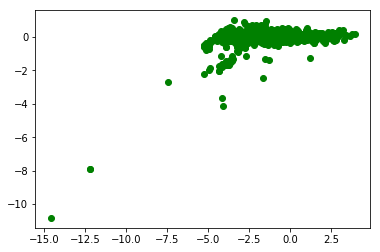

In [81]:
# some quality metrics. Plot true values versus residual
#rss = sum((lm.predict(X_btc_price_combo)-df_combo["btc_price_log"])**2)
#print rss
plt.scatter(df_combo["btc_price_log"], df_combo["btc_price_log"] - lm.predict(X_btc_price_combo), color="g")
#plt.xlabel("True Values")
#plt.ylabel("Predicted Values resid")
#plt.show()

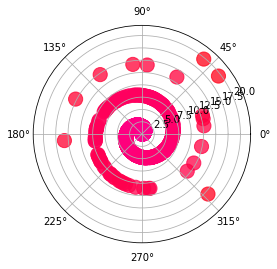

In [82]:
# Experimental chart

r = 20 * (df_combo["btc_price_log"] - lm.predict(X_btc_price_combo))
theta = 20 * np.pi * (df_combo["btc_price_log"] - lm.predict(X_btc_price_combo))
area = 100 * r**2
colors = theta

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(r, r, c=colors, s=200, cmap='hsv', alpha=0.75)

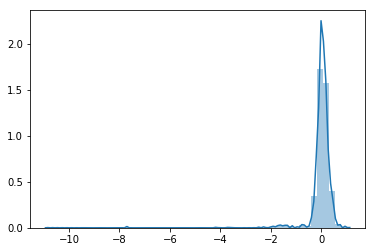

In [83]:
sns.distplot(results.resid)

## 

<a name='model_result'></a>
Result:  MSE:  0.285987248101 and  R2: 0.912521649006 show that the model is worth to consider. Many statistical significant variable factors are good for our goal to explore the price. 

Although, the residual distribution chart shows that the model has noticeable bias error. So some factors are not considered here or data sample isnt represent the full population.


### Report 1 Gram of Q75 by Country of shipment 
<a name="rep_1"></a>

In [84]:
## rate of BTC to AUD in July 2017
CurrencyRate = 3050

In [85]:
#create a reporting table based on prediction of 1 gram of quality 75% from different countries
Country = []
Cost = []  
df_predict = pd.DataFrame({'Predict' : 0
                           }, index = X_btc_price_combo_col).T

#df_predict['escrow'] = 1
df_predict['quality_75.0'] = 1
df_predict['grams_1.0'] = 1
df_predict['ships_to_GB'] = 1


for q in X_btc_price_combo_col:
    #go through the loop of ships_from_ prefix predictors 
    if 'ships_from_' in q:
        df_predict[q] = 1
        Country.append(q)
        Cost.append(np.exp(lm.predict(df_predict)) * CurrencyRate)
        df_predict[q] = 0
       # print q, np.exp(lm.predict(df_predict)) * CurrencyRate

df_plt_by_country = pd.DataFrame({ 'Country' : Country,
                       'Cost' : Cost
                         })
df_plt_by_country['Cost_num'] = df_plt_by_country['Cost'].astype(float)



<a id="(#report_by_country"></a>

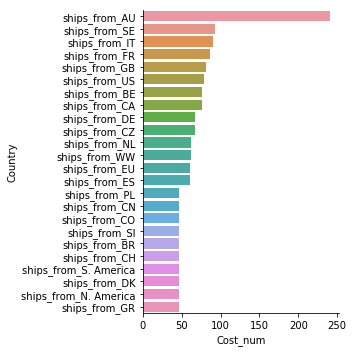

In [86]:
#Report predicted Cost by Country
sns.factorplot(
    y='Country',
    x='Cost_num',
    data=df_plt_by_country.sort_values('Cost_num',ascending=False ), 
    kind='bar', 
    size = 5,
     aspect=1,
orient = 'h'
)

*Result: Australia has the most expecncive cocaine. GB has the cheapest cocaine.*

### Report 2 Cost per gram of Q90 by Grams Pack in Australia
<a name="rep_2"></a>

In [135]:
Grams = []
Cost = []  


df_predict = pd.DataFrame({'Predict' : 0
                           }, index = X_btc_price_combo_col).T

#df_predict['escrow'] = 1
##df_predict['quality_90.0'] = 1
#d#f_predict['ships_to_AU'] = 1
#df_predict['ships_from_AU'] = 1
#df_predict['grams_1.0'] = 1

CurrencyRate = 3050
df_check = pd.DataFrame({ 'btc' : float,
                       'Cost' : float
                         }, index = [1])
df_check['Cost'] = np.exp(lm.predict(df_predict)) * CurrencyRate
df_check['btc'] = np.exp(lm.predict(df_predict))
df_check['log'] = lm.predict(df_predict)
df_check['rate'] = CurrencyRate


print df_check
for q in X_btc_price_combo_col:
    #go through the loop of ships_from_ prefix predictors 
    if 'grams_' in q:
        df_predict[q] = 1
        Grams.append(q)
        Cost.append(np.exp(lm.predict(df_predict)) * CurrencyRate)
        df_predict[q] = 0
       # print q, np.exp(lm.predict(df_predict)) * CurrencyRate

df_plt_by_grams = pd.DataFrame({ 'Grams' : Grams,
                       'Cost' : Cost
                         })
#Convert to numeric and calcualte cost per gram
df_plt_by_grams['Cost_num'] = df_plt_by_grams['Cost'].astype(float)
df_plt_by_grams[['Cost_num', 'Grams']]
df_plt_by_grams['Grams_num'] = df_plt_by_grams['Grams'].map(lambda x: str(x)[6:]).astype(float)
df_plt_by_grams['Cost_per_gram'] =df_plt_by_grams['Cost_num'] /  df_plt_by_grams['Grams_num'] 

#print df_plt_by_grams

        Cost      btc       log  rate
1  14.882924  0.00488 -5.322682  3050


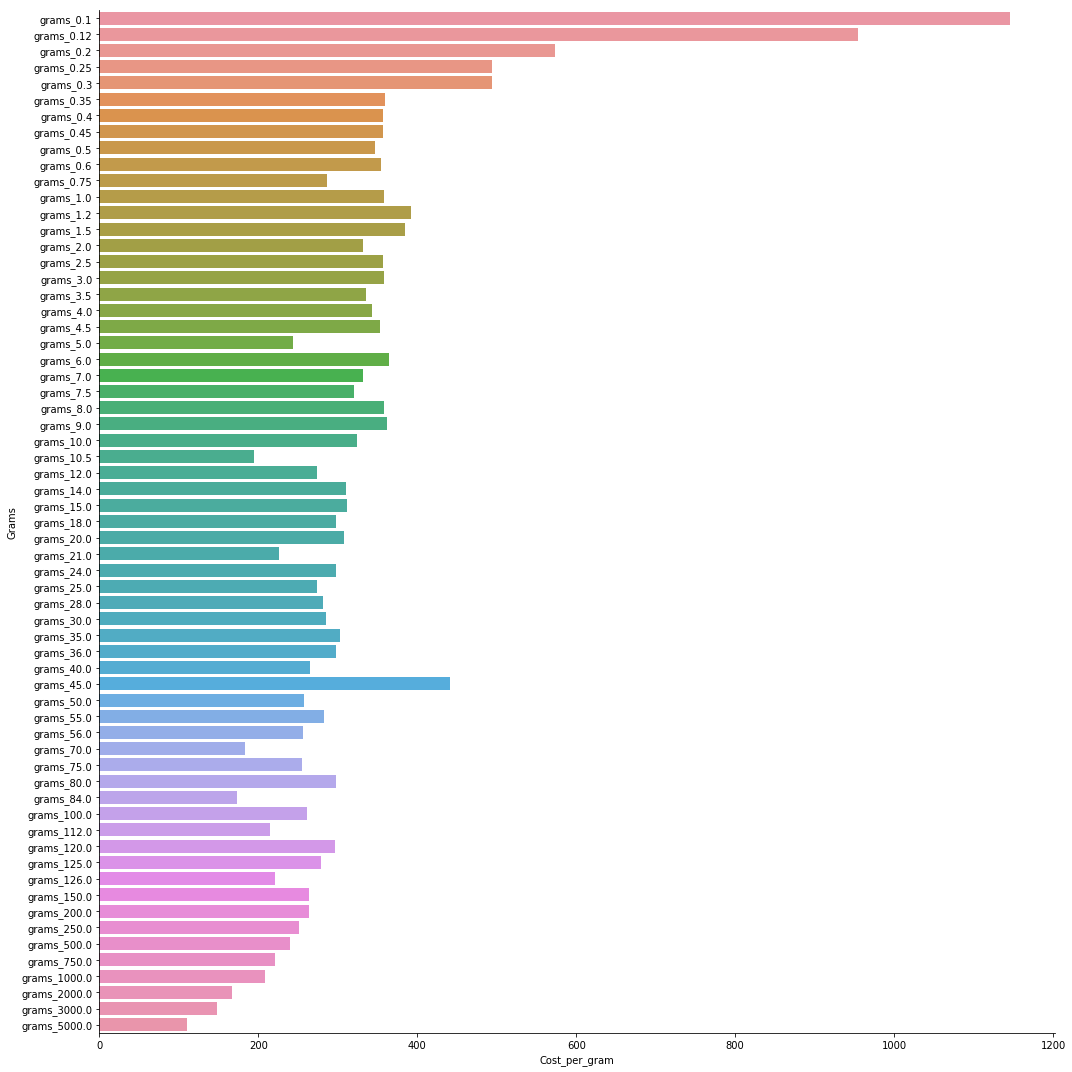

In [88]:
sns.factorplot(
    y='Grams',
    x='Cost_per_gram',
    data=df_plt_by_grams.sort_values('Grams_num',ascending=True ), 
    kind='bar', 
    size = 15,
     aspect=1,
orient = 'h'
)

*Result: The relation isnt perfcet, but we can see clear trend that more volume we take, less cost per gram it has*
*It is quite expecnive to buy packs up to 0.3g. The next level of discounts starts from packs of 10g

### Report 3  Cost for 1 gram by Quality in AU
<a name="rep_3"></a>

In [121]:
#create a reporting table based on prediction of 1 gram  by quality variables in Australia
Quality = []
Cost = []  
df_predict = pd.DataFrame({'Predict' : 0
                           }, index = X_btc_price_combo_col).T
#df_predict['escrow'] = 1
#df_predict['ships_to_AU'] = 1
#df_predict['ships_from_AU'] = 1
#df_predict['grams_1.0'] = 1

for q in X_btc_price_combo_col:
    #go through the loop of quality_ prefix predictors 
    if 'quality_' in q:
        df_predict[q] = 1
        Quality.append(q)
        Cost.append((lm.predict(df_predict)))
        df_predict[q] = 0
       # print q, np.exp(lm.predict(df_predict)) * CurrencyRate

    
df_plt_by_qa = pd.DataFrame({ 'quality' : Quality,
                       'Cost' : Cost
                         })

df_plt_by_qa['Cost_num'] = df_plt_by_qa['Cost'].astype(float)



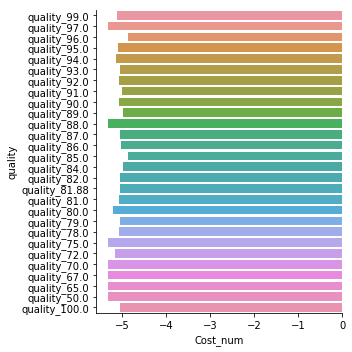

In [122]:
sns.factorplot(
    y='quality',
    x='Cost_num',
    data=df_plt_by_qa.sort_values('quality',ascending=False ), 
    kind='bar', 
    size = 5,
     aspect=1,
orient = 'h'
)

*Result: as expected, there is no or weak relation between quality and price*

### Repot 4. Factor plot
<a name="rep_4"></a>

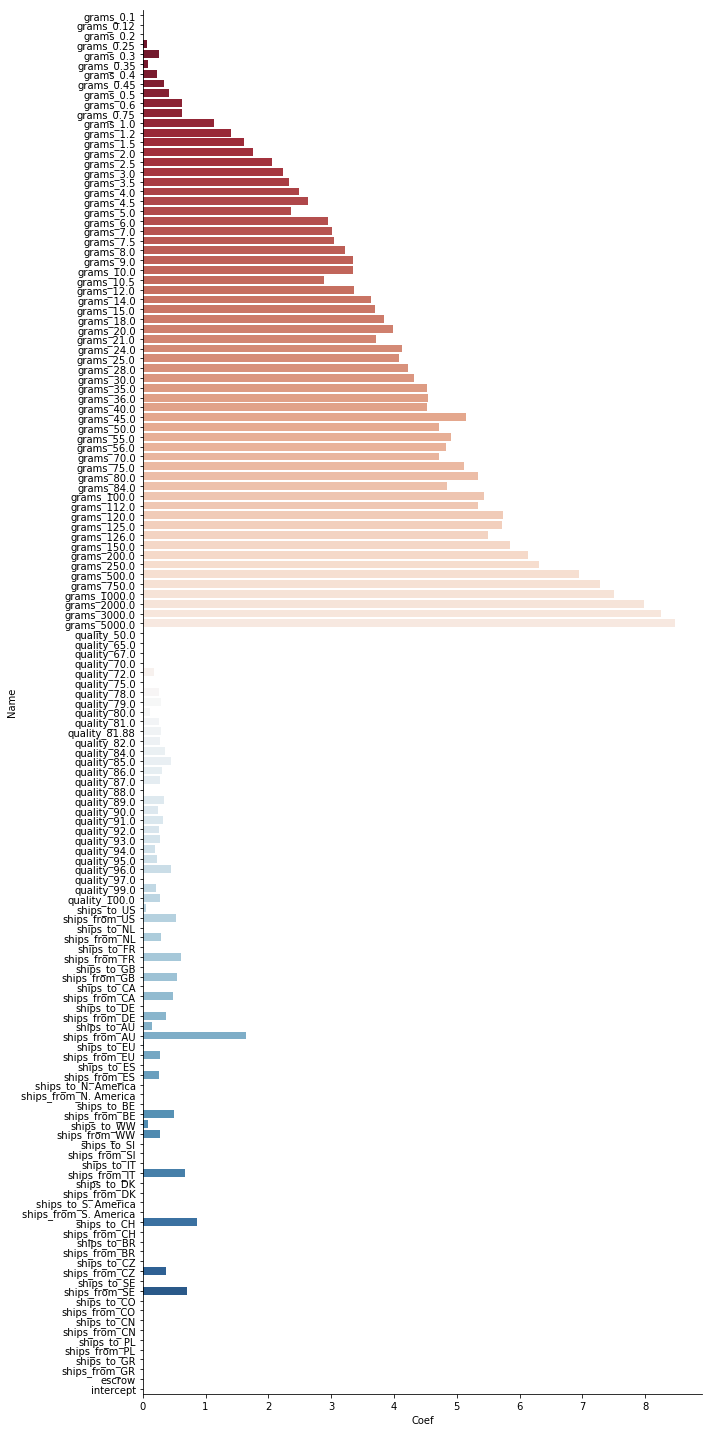

In [91]:
df_coef = pd.DataFrame({'Coef' : lm.coef_,
                         'Inercept' : lm.intercept_,
                        'Name': X_btc_price_combo_col
                           }, index = X_btc_price_combo_col)

sns.factorplot(
    y='Name',
    x='Coef',
    data=df_coef, 
    kind='bar', 
    size = 20,
     aspect=0.5,
orient = 'h',
     legend_out=True,
    palette = 'RdBu'
)

In [134]:
df_coef.to_csv('C:/Users/Denis/DAT5melb2/dreamworld/coef.csv') 

Overall Result: 
- The most influence factor set are grams. 
- Quite noticeable that some countries have a positive coefficient which increases the price. 
- Australia has the most impactful coefficient. 
- Quality, also has different corrections.
- Shipment to has almost no impact on price. (except Australia)

Overall, I feel that the result is quite reasonable. The biggest advantage of the model in comparison with table aggregation is that we can predict and show the answers to which we have no direct intersections.


### Next steps
<a name="next"></a>

As a further improvement, the classification of quality categories can be done more properly.
the exploration within one country by vendor and get from the short description the country of origin and if the product 'right from the brick' can be interesting direction.

I feel there will be a great check if I the model can be applied for another similar shop

History of the sales with customer ID (as well as Facebook link) and date reference can significantly improve the model.
